In [ ]:
"""
Purpose: To test the visualizations 
of just takig the average of node features

Psueodocode: 
1) Get the all batch data
2) Average across all of the batches
3) Plot with the given labels

"""

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import datajoint as dj
import trimesh
from tqdm.notebook import tqdm
from pathlib import Path

from os import sys
sys.path.append("/meshAfterParty/meshAfterParty")
sys.path.append("/python_tools/python_tools")
sys.path.append("/machine_learning_tools/machine_learning_tools/")
sys.path.append("/graph_tools/graph_tools/")
sys.path.append("/neuron_morphology_tools/neuron_morphology_tools/")

import datajoint_utils as du
from importlib import reload

WARNING - 2022-05-04 08:59:23,326 - _default - No project ID could be determined. Consider running `gcloud config set project` or setting the GOOGLE_CLOUD_PROJECT environment variable


Using default Google credentials. There is no ~/.cloudvolume/secrets/google-secret.json set.


INFO - 2022-05-04 08:59:25,483 - settings - Setting enable_python_native_blobs to True
INFO - 2022-05-04 08:59:25,484 - settings - Setting stores to {'h01_skeletons': {'protocol': 'file', 'location': '/mnt/dj-stor01/microns/h01/skeletons', 'stage': '/mnt/dj-stor01/microns/h01/skeletons'}, 'h01_meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/microns/h01/meshes', 'stage': '/mnt/dj-stor01/microns/h01/meshes'}, 'h01_faces': {'protocol': 'file', 'location': '/mnt/dj-stor01/microns/h01/faces', 'stage': '/mnt/dj-stor01/microns/h01/faces'}, 'h01_decimated_meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/microns/h01/decimated_meshes', 'stage': '/mnt/dj-stor01/microns/h01/decimated_meshes'}, 'h01_soma_meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/microns/h01/soma_meshes', 'stage': '/mnt/dj-stor01/microns/h01/soma_meshes'}}
INFO - 2022-05-04 08:59:25,495 - connection - Connected celiib@at-database.ad.bcm.edu:3306


Connecting celiib@at-database.ad.bcm.edu:3306


INFO - 2022-05-04 08:59:26,561 - settings - Setting enable_python_native_blobs to True
WARNING - 2022-05-04 08:59:30,295 - utils - DataJointPlus version check failed.
INFO - 2022-05-04 08:59:31,975 - settings - Setting enable_python_native_blobs to True
ERROR - 2022-05-04 08:59:31,998 - compatibility - Could not add DataJointPlus to ImportMethod.
Traceback (most recent call last):
  File "/datajoint-plus/datajoint_plus/compatibility.py", line 41, in add_datajoint_plus
    obj.parse_hash_info_from_header()
  File "/datajoint-plus/datajoint_plus/base.py", line 354, in parse_hash_info_from_header
    if result[0] == attr:
IndexError: list index out of range
ERROR - 2022-05-04 08:59:32,047 - compatibility - Could not add DataJointPlus to Materialization.
Traceback (most recent call last):
  File "/datajoint-plus/datajoint_plus/compatibility.py", line 41, in add_datajoint_plus
    obj.parse_hash_info_from_header()
  File "/datajoint-plus/datajoint_plus/base.py", line 354, in parse_hash_info

In [3]:
from microns_morphology_api.schemas import minnie65_morphology as m65mor
m65mor.config.register_adapters(context=locals())
m65mor.config.register_externals()

from microns_morphology_api.schemas import minnie65_auto_proofreading as m65auto
m65auto.config.register_adapters(context=locals())
m65auto.config.register_externals()

In [4]:
from dataInterfaceMinnie65 import data_interface as hdju

In [5]:
import neuron_nx_utils as nxu
import networkx_utils as xu
import morphopy_utils as mpu

In [6]:
import dimensionality_reduction_ml as dru
import preprocessing_ml as preml
import pandas_ml as pdml
import pandas_utils as pu
import visualizations_ml as vml
import system_utils as su

In [7]:
#python_tools modules
import system_utils as su
import pandas_utils as pu
import pandas as pd
import numpy as np
import numpy_utils as nu
import networkx_utils as xu
from tqdm_utils import tqdm

#neuron_morphology_tools modules
import neuron_nx_io as nxio

# Loading the Data

In [8]:
with_skeleton = False

features_to_delete = [
    "mesh_volume",
    "apical_label",
    "basal_label",
]

if not with_skeleton:
    features_to_delete +=[
        "skeleton_vector_downstream_phi",      
        "skeleton_vector_downstream_theta",    
        "skeleton_vector_upstream_phi",        
        "skeleton_vector_upstream_theta",  
    ]

features_to_keep = None

In [10]:
import system_utils as su
data_path = Path("./data/m65_full/")
#list(data_path.iterdir())

gnn_task = "cell_type_fine"
label_name = None
graph_label = "cell_type_fine_label"
data_file = "df_cell_type_fine.pbz2"

data_filepath = Path(data_path) / Path(data_file)

data_df = su.decompress_pickle(data_filepath)
data_df

,segment_id,split_index,nucleus_id,external_layer,external_visual_area,cell_type_fine,cell_type_fine_label
0,864691134277239760,0,89719,LAYER_6,V1,"[{'nodelist': ['L0_0'], 'features': ['mesh_vol...",NaN
1,864691134339067925,0,624899,LAYER_6,AL,"[{'nodelist': ['L0_1', 'L0_0', 'L0_2'], 'featu...",NaN
2,864691134366116139,0,476756,WHITE_MATTER,RL,"[{'nodelist': ['L0_6'], 'features': ['mesh_vol...",NaN
3,864691134378215335,0,3799,LAYER_2/3,V1,"[{'nodelist': ['L0_1', 'L0_0', 'L0_2'], 'featu...",NaN
4,864691134527727930,0,631380,WHITE_MATTER,RL,"[{'nodelist': ['L0_0'], 'features': ['mesh_vol...",NaN
...,...,...,...,...,...,...,...
60448,864691137197334593,0,376218,LAYER_6,V1,"[{'nodelist': ['L0_0', 'L0_1', 'L0_2', 'L0_5',...",NaN
60449,864691137197344065,0,191436,LAYER_2/3,V1,"[{'nodelist': ['L0_0', 'L0_1', 'L0_4', 'L0_6',...",NaN
60450,864691137197345345,0,584463,LAYER_2/3,RL,"[{'nodelist': ['L0_13', 'L4_5', 'L0_8', 'L2_5'...",NaN
60451,864691137197353281,0,591241,LAYER_5,RL,"[{'nodelist': ['L4_6', 'L1_10', 'L3_4', 'L0_10...",NaN


In [11]:
x_list = []
y_list = data_df[graph_label].to_list()
for gnn_info in data_df[gnn_task].to_list():
    x = nxio.feature_df_from_gnn_info(
        gnn_info[0],
        return_data_labels_split = False)
    x_list.append(x)

In [12]:
df_mean_features = pd.concat([k.mean() for k in x_list],axis=1).T
df_mean_features

,mesh_volume,n_spines,n_synapses_head,n_synapses_neck,n_synapses_post,n_synapses_pre,skeletal_length,total_spine_volume,width_upstream,width_downstream,apical_label,basal_label,skeleton_vector_downstream_phi,skeleton_vector_downstream_theta,skeleton_vector_upstream_phi,skeleton_vector_upstream_theta,width_no_spine
0,38.331768,0.000000,0.000000,0.000000,0.000000,0.000000,4218.736339,0.000000e+00,1033.341211,895.524963,0.000000,1.000000,1.301845,1.421399,1.283103,1.385306,908.503296
1,12.668272,0.000000,0.000000,0.000000,0.000000,0.000000,4330.474477,0.000000e+00,242.740854,458.988261,0.000000,1.000000,1.197327,1.442915,-0.801018,1.604856,391.516995
2,5.177527,0.000000,0.000000,0.000000,0.000000,0.000000,3206.663214,0.000000e+00,531.441932,366.946082,0.000000,1.000000,-0.809102,1.300793,-0.886743,1.278941,493.809220
3,7.664839,0.000000,0.000000,0.000000,0.000000,0.000000,1835.836478,0.000000e+00,646.265925,621.255990,0.000000,1.000000,-0.591096,1.520675,-0.612847,1.517428,646.221959
4,24.522745,0.000000,0.000000,0.000000,0.000000,3.000000,4493.930145,0.000000e+00,1590.580997,1427.002798,0.000000,1.000000,-2.036848,1.493445,-2.410269,1.731865,1448.651585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60448,1742.106571,14.363636,9.545455,0.136364,29.022727,0.409091,40225.071793,3.285510e+09,428.427795,396.536893,0.522727,0.477273,-0.447277,1.871510,-0.480220,1.857945,377.628211
60449,1327.281437,27.066667,12.888889,0.555556,48.688889,0.266667,36129.369549,5.423866e+09,457.316744,484.810322,0.333333,0.666667,0.579261,1.675562,0.186345,1.696517,436.543691
60450,2531.083995,34.970149,20.208955,1.388060,73.940299,0.238806,56240.411769,9.597279e+09,528.075821,476.483935,0.462687,0.537313,-0.112930,1.759388,-0.048703,1.670131,451.458443
60451,699.817346,3.817204,2.172043,0.258065,55.215054,0.365591,32355.196705,6.064745e+08,334.447591,319.793766,0.000000,0.000000,-0.205154,1.564871,0.257373,1.569964,314.443104


In [13]:
label_name = "cell_type_fine_label"
df_mean_features[label_name] = y_list
df_mean_features

,mesh_volume,n_spines,n_synapses_head,n_synapses_neck,n_synapses_post,n_synapses_pre,skeletal_length,total_spine_volume,width_upstream,width_downstream,apical_label,basal_label,skeleton_vector_downstream_phi,skeleton_vector_downstream_theta,skeleton_vector_upstream_phi,skeleton_vector_upstream_theta,width_no_spine,cell_type_fine_label
0,38.331768,0.000000,0.000000,0.000000,0.000000,0.000000,4218.736339,0.000000e+00,1033.341211,895.524963,0.000000,1.000000,1.301845,1.421399,1.283103,1.385306,908.503296,NaN
1,12.668272,0.000000,0.000000,0.000000,0.000000,0.000000,4330.474477,0.000000e+00,242.740854,458.988261,0.000000,1.000000,1.197327,1.442915,-0.801018,1.604856,391.516995,NaN
2,5.177527,0.000000,0.000000,0.000000,0.000000,0.000000,3206.663214,0.000000e+00,531.441932,366.946082,0.000000,1.000000,-0.809102,1.300793,-0.886743,1.278941,493.809220,NaN
3,7.664839,0.000000,0.000000,0.000000,0.000000,0.000000,1835.836478,0.000000e+00,646.265925,621.255990,0.000000,1.000000,-0.591096,1.520675,-0.612847,1.517428,646.221959,NaN
4,24.522745,0.000000,0.000000,0.000000,0.000000,3.000000,4493.930145,0.000000e+00,1590.580997,1427.002798,0.000000,1.000000,-2.036848,1.493445,-2.410269,1.731865,1448.651585,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60448,1742.106571,14.363636,9.545455,0.136364,29.022727,0.409091,40225.071793,3.285510e+09,428.427795,396.536893,0.522727,0.477273,-0.447277,1.871510,-0.480220,1.857945,377.628211,NaN
60449,1327.281437,27.066667,12.888889,0.555556,48.688889,0.266667,36129.369549,5.423866e+09,457.316744,484.810322,0.333333,0.666667,0.579261,1.675562,0.186345,1.696517,436.543691,NaN
60450,2531.083995,34.970149,20.208955,1.388060,73.940299,0.238806,56240.411769,9.597279e+09,528.075821,476.483935,0.462687,0.537313,-0.112930,1.759388,-0.048703,1.670131,451.458443,NaN
60451,699.817346,3.817204,2.172043,0.258065,55.215054,0.365591,32355.196705,6.064745e+08,334.447591,319.793766,0.000000,0.000000,-0.205154,1.564871,0.257373,1.569964,314.443104,NaN


In [14]:
import pandas_utils as pu
keep_idx = pu.find_all_rows_without_nan(df_mean_features)
df_no_nan = df_mean_features.iloc[keep_idx,:]
df_no_nan

,mesh_volume,n_spines,n_synapses_head,n_synapses_neck,n_synapses_post,n_synapses_pre,skeletal_length,total_spine_volume,width_upstream,width_downstream,apical_label,basal_label,skeleton_vector_downstream_phi,skeleton_vector_downstream_theta,skeleton_vector_upstream_phi,skeleton_vector_upstream_theta,width_no_spine,cell_type_fine_label
115,3157.472760,29.510204,27.387755,1.122449,54.265306,0.163265,63459.387871,9.915846e+09,354.012040,325.776855,0.387755,0.612245,-0.407786,1.477198,-0.339517,1.586607,319.876474,4P
147,2395.963716,24.957447,19.787234,0.872340,45.936170,0.340426,48878.785895,7.387531e+09,402.445356,382.128097,0.148936,0.851064,0.133330,1.725845,0.507438,1.691387,358.585285,23P
170,1824.777875,22.159091,11.886364,0.386364,40.090909,0.386364,44896.342922,4.077180e+09,370.587119,357.095115,0.477273,0.522727,-0.890652,1.608997,-0.349807,1.612648,330.567213,5P_IT
205,5744.373331,39.342105,24.394737,0.789474,77.157895,0.394737,94343.592144,8.440558e+09,463.627233,436.203129,0.394737,0.605263,-0.521413,1.404861,0.346054,1.503700,415.734064,IT_short
213,624.507956,16.030303,11.757576,0.696970,44.393939,0.090909,33456.548997,4.028807e+09,430.065373,391.869997,0.000000,1.000000,0.022357,1.278431,-0.241101,1.364545,363.667549,23P
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60416,4304.036313,44.937500,35.062500,2.093750,78.625000,0.843750,75996.749394,1.362436e+10,387.418975,346.260221,0.250000,0.750000,0.683429,1.487670,0.178978,1.448678,372.238007,4P
60417,1231.324269,5.934783,2.586957,0.391304,86.782609,0.586957,53558.647234,9.234019e+08,344.323951,341.275743,0.000000,0.000000,-0.031499,1.418151,-0.419247,1.469525,348.238868,Unsure
60433,5852.538631,9.821429,6.142857,0.142857,28.500000,0.607143,93168.734903,1.749903e+09,311.301899,316.368101,0.321429,0.678571,0.196067,1.629841,0.210191,1.638607,290.390946,5P_NP
60442,4164.778997,27.358974,19.435897,0.666667,66.102564,0.461538,79509.467579,6.878130e+09,452.545315,400.128540,0.487179,0.512821,-0.360115,1.424588,-0.278695,1.570448,393.641946,6P


# Step 6: Plotting Embeddings

In [15]:
data_cols = [k for k in df_no_nan if k != label_name and k not in features_to_delete]

In [70]:
data_cols

['n_spines',
 'n_synapses_head',
 'n_synapses_neck',
 'n_synapses_post',
 'n_synapses_pre',
 'skeletal_length',
 'total_spine_volume',
 'width_upstream',
 'width_downstream',
 'skeleton_vector_downstream_phi',
 'skeleton_vector_downstream_theta',
 'skeleton_vector_upstream_phi',
 'skeleton_vector_upstream_theta',
 'width_no_spine']

In [16]:
target_name = label_name
df = df_no_nan[data_cols + [target_name]]
df

import pandas_utils as pu
df = pu.filter_away_non_finite_rows(df)
df

,n_spines,n_synapses_head,n_synapses_neck,n_synapses_post,n_synapses_pre,skeletal_length,total_spine_volume,width_upstream,width_downstream,skeleton_vector_downstream_phi,skeleton_vector_downstream_theta,skeleton_vector_upstream_phi,skeleton_vector_upstream_theta,width_no_spine,cell_type_fine_label
115,29.510204,27.387755,1.122449,54.265306,0.163265,63459.387871,9.915846e+09,354.012040,325.776855,-0.407786,1.477198,-0.339517,1.586607,319.876474,4P
147,24.957447,19.787234,0.872340,45.936170,0.340426,48878.785895,7.387531e+09,402.445356,382.128097,0.133330,1.725845,0.507438,1.691387,358.585285,23P
170,22.159091,11.886364,0.386364,40.090909,0.386364,44896.342922,4.077180e+09,370.587119,357.095115,-0.890652,1.608997,-0.349807,1.612648,330.567213,5P_IT
205,39.342105,24.394737,0.789474,77.157895,0.394737,94343.592144,8.440558e+09,463.627233,436.203129,-0.521413,1.404861,0.346054,1.503700,415.734064,IT_short
213,16.030303,11.757576,0.696970,44.393939,0.090909,33456.548997,4.028807e+09,430.065373,391.869997,0.022357,1.278431,-0.241101,1.364545,363.667549,23P
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60416,44.937500,35.062500,2.093750,78.625000,0.843750,75996.749394,1.362436e+10,387.418975,346.260221,0.683429,1.487670,0.178978,1.448678,372.238007,4P
60417,5.934783,2.586957,0.391304,86.782609,0.586957,53558.647234,9.234019e+08,344.323951,341.275743,-0.031499,1.418151,-0.419247,1.469525,348.238868,Unsure
60433,9.821429,6.142857,0.142857,28.500000,0.607143,93168.734903,1.749903e+09,311.301899,316.368101,0.196067,1.629841,0.210191,1.638607,290.390946,5P_NP
60442,27.358974,19.435897,0.666667,66.102564,0.461538,79509.467579,6.878130e+09,452.545315,400.128540,-0.360115,1.424588,-0.278695,1.570448,393.641946,6P


# Dim Reduction

In [17]:
"""
Source code: https://github.com/berenslab/mini-atlas/blob/master/code/phenotype-tsne.ipynb
saved_in file: m1_patchseq_morph_features

"""

'\nSource code: https://github.com/berenslab/mini-atlas/blob/master/code/phenotype-tsne.ipynb\nsaved_in file: m1_patchseq_morph_features\n\n'

In [18]:
import pandas_utils as pu
import preprocessing_ml as preml
embedding_df = df
target_name = "cell_type_label"
embedding_df = pu.rename_columns(embedding_df,
                                dict(cell_type_fine_label=target_name))

#need to scale
embedding_df = preml.scale_df(
    embedding_df,target_name=target_name)
embedding_df

,n_spines,n_synapses_head,n_synapses_neck,n_synapses_post,n_synapses_pre,skeletal_length,total_spine_volume,width_upstream,width_downstream,skeleton_vector_downstream_phi,skeleton_vector_downstream_theta,skeleton_vector_upstream_phi,skeleton_vector_upstream_theta,width_no_spine,cell_type_label
0,0.539178,1.323001,0.691586,-0.000662,-1.062140,0.354974,1.241310,-0.876252,-0.813146,-0.659271,-0.965024,-0.481555,0.003202,-0.917685,4P
1,0.108191,0.407493,0.223332,-0.435370,-0.138549,-0.667606,0.462150,0.077935,0.409388,0.777613,1.212083,1.779783,0.945783,-0.020771,23P
2,-0.156715,-0.544192,-0.686516,-0.740441,0.100941,-0.946906,-0.558013,-0.549706,-0.133700,-1.941477,0.188984,-0.509028,0.237459,-0.669972,5P_IT
3,1.469915,0.962482,0.068189,1.194131,0.144593,2.520972,0.786665,1.283281,1.582539,-0.960995,-1.598389,1.348894,-0.742618,1.303412,IT_short
4,-0.736897,-0.559705,-0.104998,-0.515861,-1.439355,-1.749212,-0.572920,0.622078,0.620737,0.482936,-2.705381,-0.218789,-1.994432,0.096989,23P
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3333,1.999603,2.247450,2.510060,1.270701,2.485437,1.234255,2.384176,-0.218101,-0.368762,2.238353,-0.873333,0.902808,-1.237582,0.295574,4P
3334,-1.692589,-1.664337,-0.677266,1.696456,1.146693,-0.339394,-1.529924,-1.067117,-0.476900,0.339927,-1.482025,-0.694430,-1.050050,-0.260505,Unsure
3335,-1.324660,-1.236017,-1.142409,-1.345385,1.251931,2.438576,-1.275219,-1.717686,-1.017268,0.944206,0.371492,0.986145,0.470980,-1.600888,5P_NP
3336,0.335532,0.365174,-0.161731,0.617139,0.492850,1.480612,0.305166,1.064956,0.799905,-0.532683,-1.425659,-0.319163,-0.142162,0.791520,6P


In [19]:
# df_scaled = df_scaled.replace(np.nan,"Unknown")
# df_scaled

# Step 6: Plotting Embeddings

In [33]:
%matplotlib notebook
import visualizations_ml as vml
n_components = 3
import dimensionality_reduction_ml as dru

In [21]:
import pandas_ml as pdml
X_data,y_labels = pdml.X_y(embedding_df,target_name)

In [80]:
X = X_data.to_numpy().astype("float")#[labeled_mask_plotting].to_numpy().astype("float")
y = y_labels.to_numpy()#[labeled_mask_plotting].to_numpy()

# Prep) PCA Preprocessing

<IPython.core.display.Javascript object>


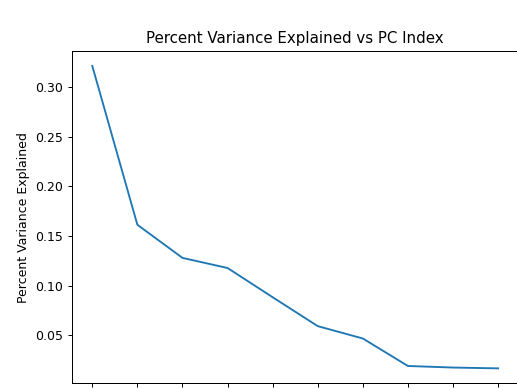

In [81]:
n_components_test=10
pca_data = dru.pca_analysis(
    X,
    n_components=n_components_test,
    plot_sqrt_eigvals=False,
    plot_perc_variance_explained=True
)

X_pca = pca_data["data_proj"]

# a) PCA

In [82]:
sys.path.append('/meshAfterParty/meshAfterParty/')
import datajoint_utils as du
import cell_type_utils as ctu

<IPython.core.display.Javascript object>


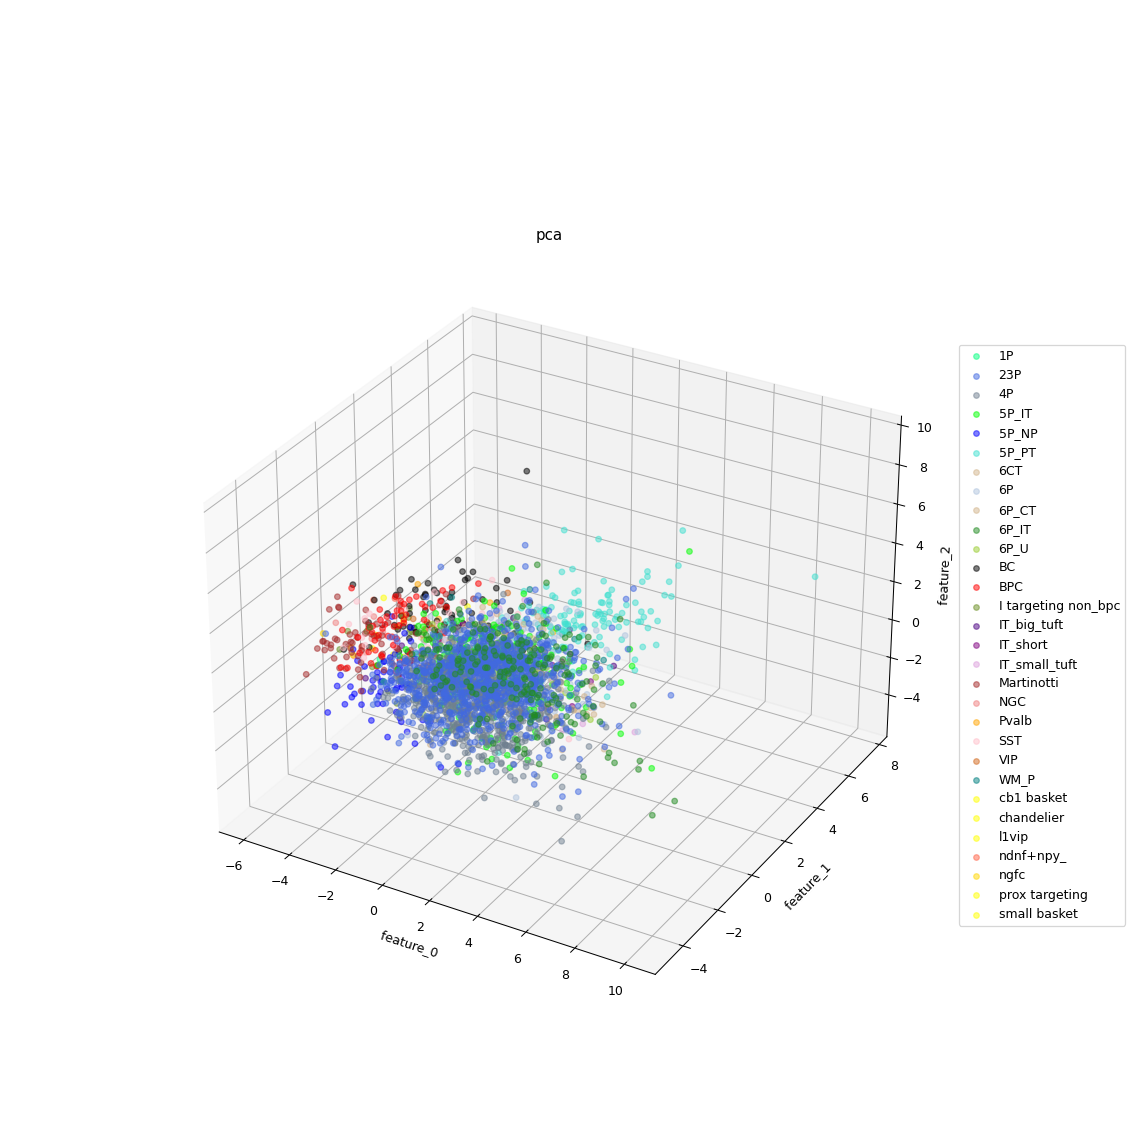

array([[ 0.63622244, -1.96607456, -0.68554035],
       [ 0.1647234 , -0.22153459, -0.50797255],
       [-1.3206224 ,  0.76235288, -1.16696098],
       ...,
       [-3.25775387, -1.50173678, -0.37088999],
       [ 1.70362786,  0.47345486,  0.94800171],
       [-2.20098962,  0.90243052, -0.66238799]])

In [83]:
import dimensionality_reduction_ml as dru
import cell_type_utils as ctu
dru.dimensionality_reduction_by_method(
    method="pca",
    X=X[y!= "Unsure"],
    y = y[y != "Unsure"],
    n_components =3,
    plot=True,
    plot_kwargs=dict(
    target_to_color = ctu.cell_type_fine_color_map,
        ndim = 3,
    )
    
)

# b) UMAP

<IPython.core.display.Javascript object>


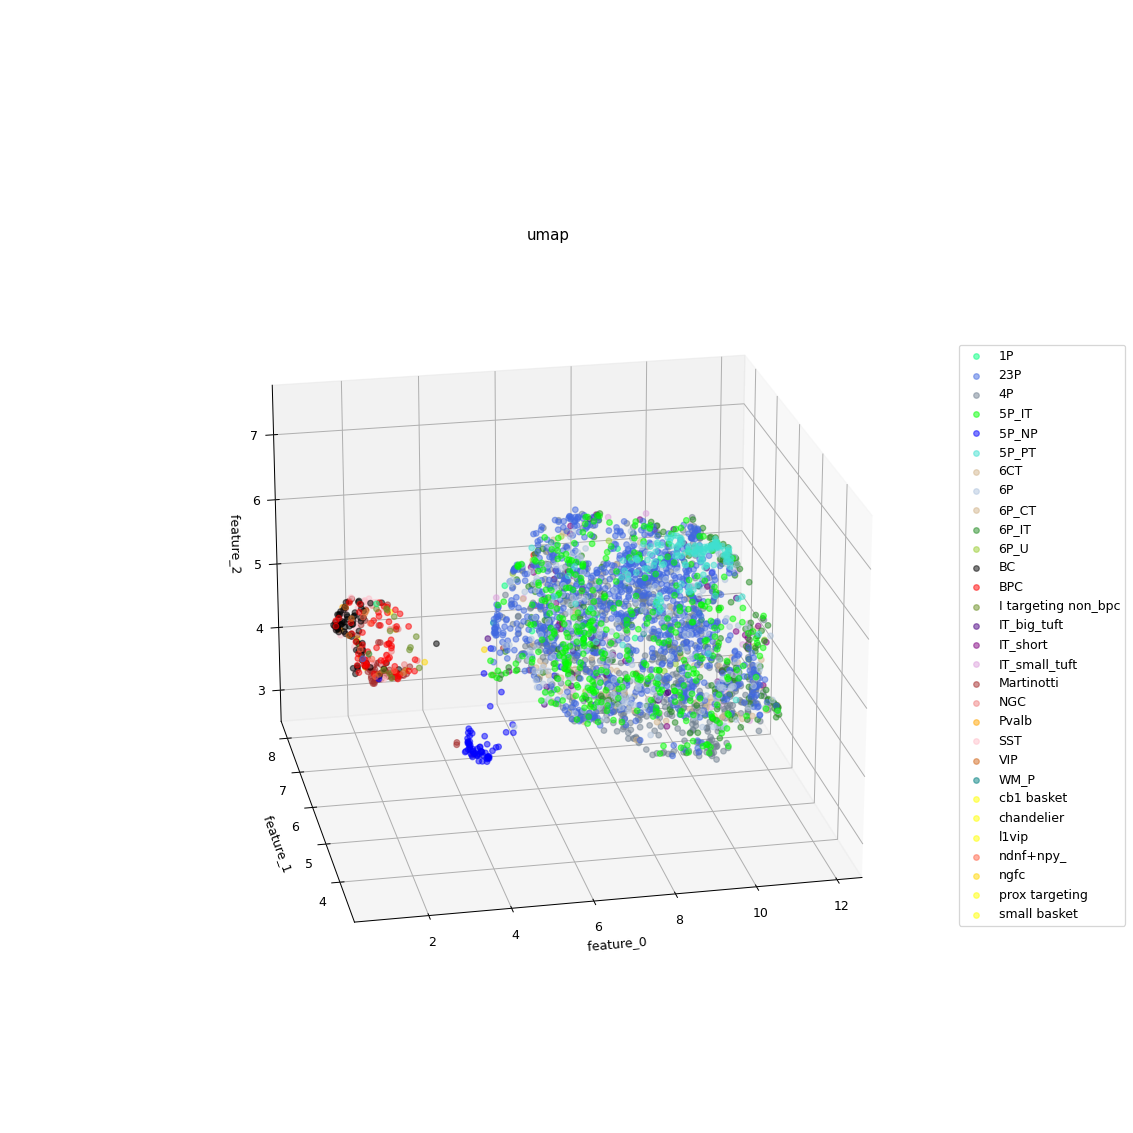

array([[ 9.924017 ,  6.299787 ,  3.4201531],
       [ 9.115179 ,  5.952394 ,  5.6386395],
       [ 6.4144826,  5.373894 ,  4.646223 ],
       ...,
       [ 4.2971315,  5.6762595,  3.2952895],
       [10.266891 ,  4.8423405,  5.3770704],
       [ 1.6237359,  6.369501 ,  5.2291427]], dtype=float32)

In [84]:
import dimensionality_reduction_ml as dru
dru.dimensionality_reduction_by_method(
    method="umap",
    X=X[y!= "Unsure"],
    y = y[y != "Unsure"],
    n_components =3,
    plot=True,
    plot_kwargs=dict(
    target_to_color = ctu.cell_type_fine_color_map,
        ndim = 3,
    )
    
)

# Isomap

<IPython.core.display.Javascript object>


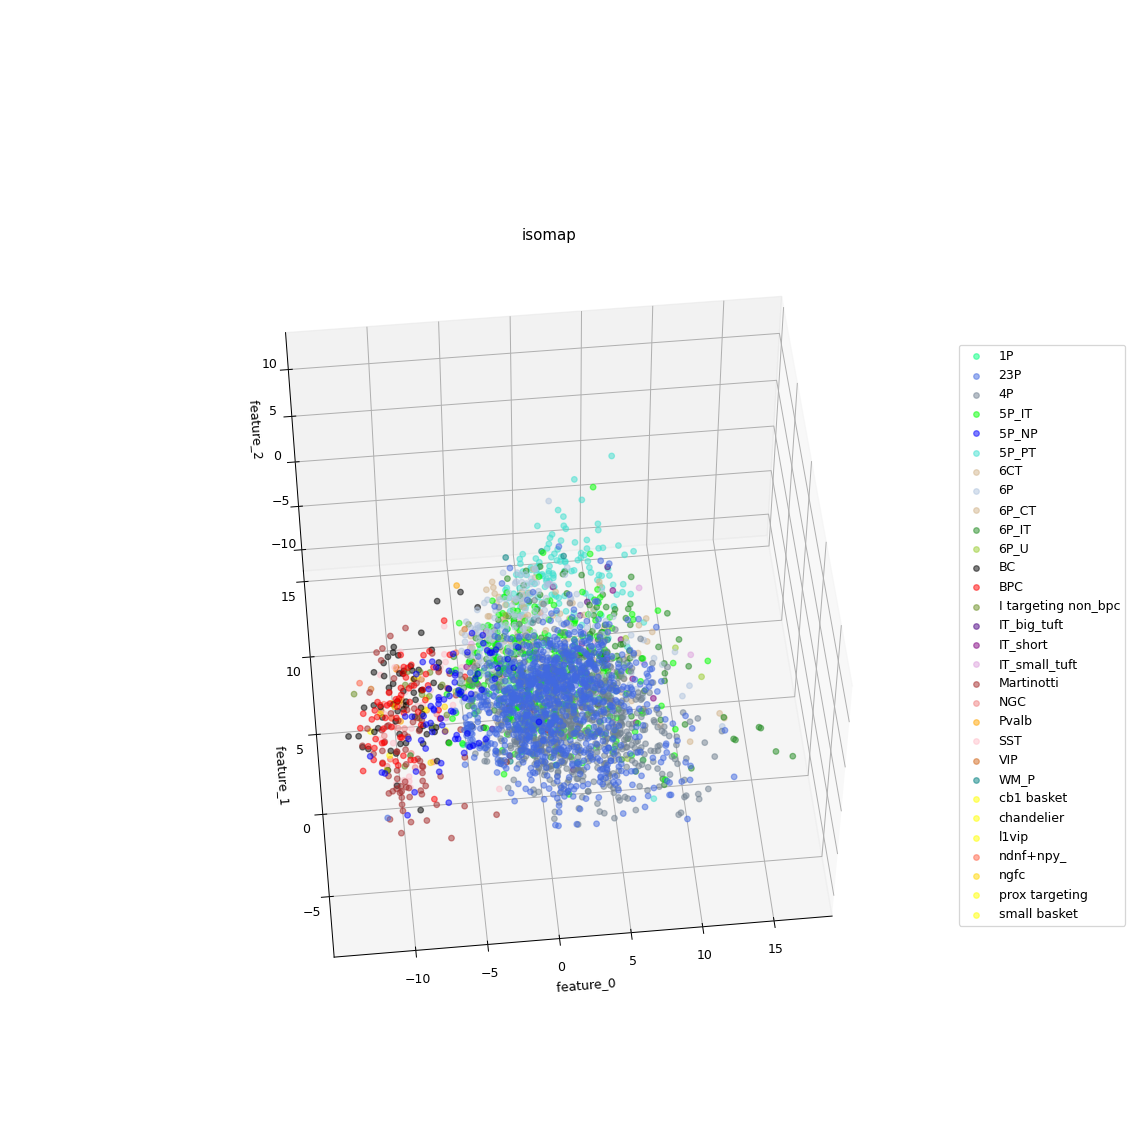

array([[ 3.89428114e+00, -3.36112043e+00, -7.48271199e-03],
       [ 2.06609539e+00, -4.93972760e-02, -4.67384657e-02],
       [-2.90239869e+00, -8.11270018e-02,  2.79491600e+00],
       ...,
       [-7.35544402e+00, -2.62560379e+00,  4.30923742e+00],
       [ 2.26642226e+00,  2.90090312e+00, -7.30691457e-01],
       [-9.26109171e+00,  3.07914009e+00, -1.83414786e+00]])

In [85]:
import dimensionality_reduction_ml as dru
dru.dimensionality_reduction_by_method(
    method="isomap",
    X=X[y!= "Unsure"],
    y = y[y != "Unsure"],
    n_components =3,
    plot=True,
    plot_kwargs=dict(
    target_to_color = ctu.cell_type_fine_color_map,
        ndim = 3,
    )
    
)

# TSNE

<IPython.core.display.Javascript object>


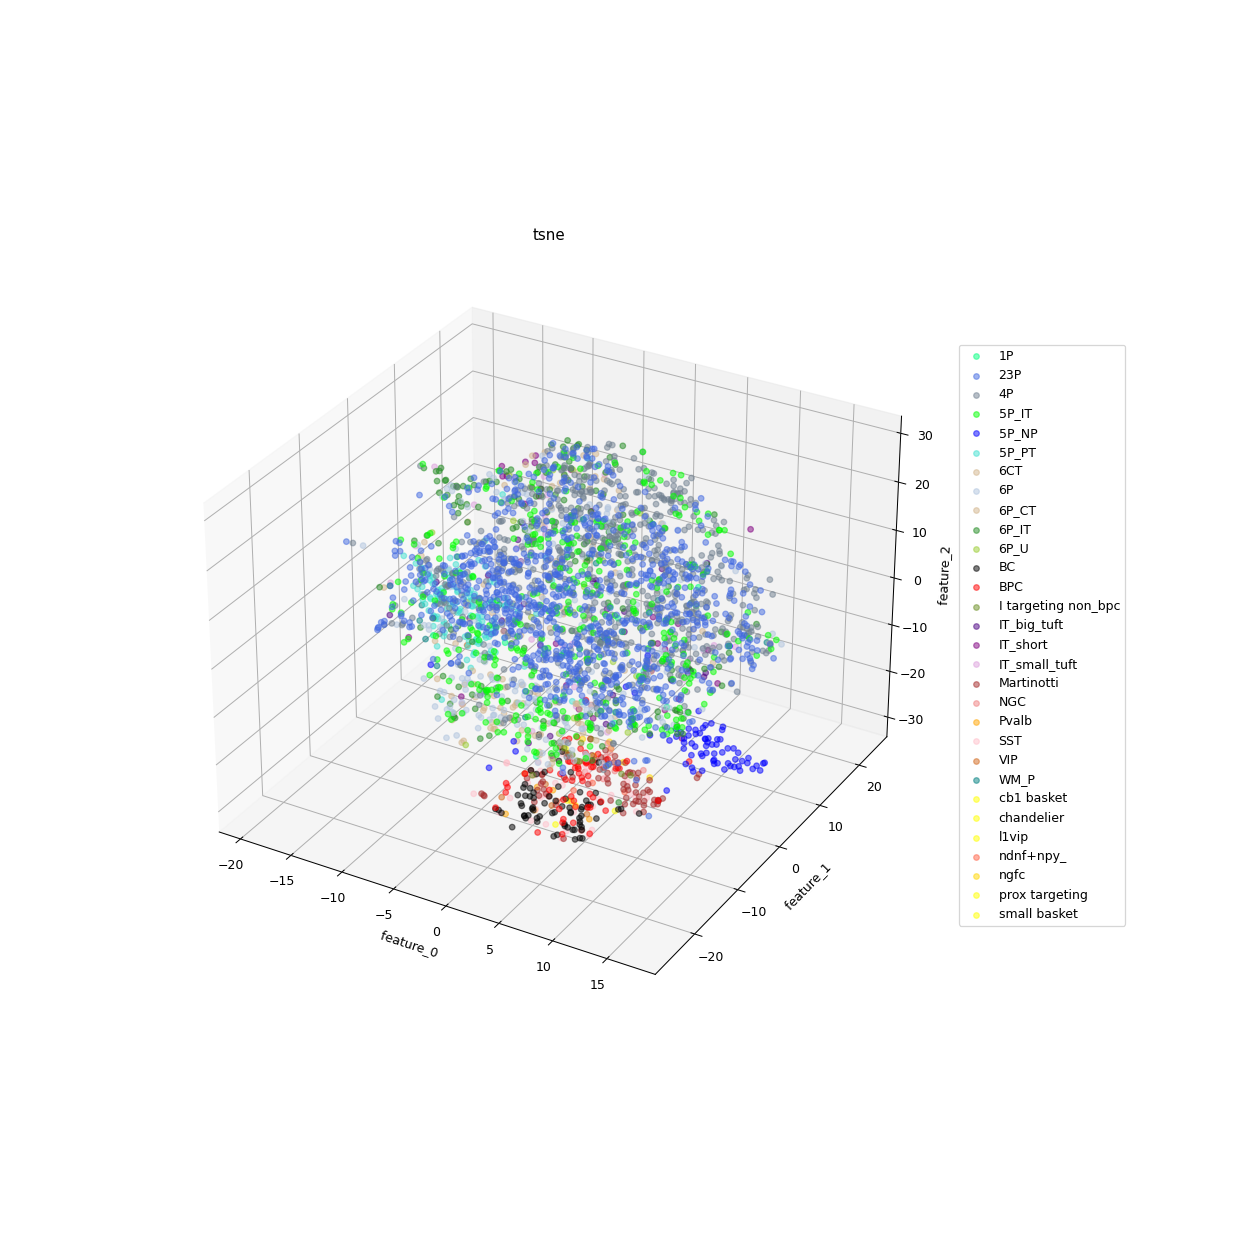

array([[ -0.36313415,  16.483475  ,   7.976786  ],
       [-13.210358  ,  -1.3517303 ,   1.2707642 ],
       [ -6.332871  ,  -3.5917008 ,  -8.607666  ],
       ...,
       [ 10.850696  ,   3.9199598 , -23.488739  ],
       [  4.6615977 ,  -7.6469035 ,  14.458095  ],
       [ -0.49942708, -14.350213  , -22.616032  ]], dtype=float32)

In [86]:
import dimensionality_reduction_ml as dru
dru.dimensionality_reduction_by_method(
    method="tsne",
    X=X[y!= "Unsure"],
    y = y[y != "Unsure"],
    n_components =3,
    plot=True,
    plot_kwargs=dict(
    target_to_color = ctu.cell_type_fine_color_map,
        ndim = 3,
    )
    
)

<IPython.core.display.Javascript object>


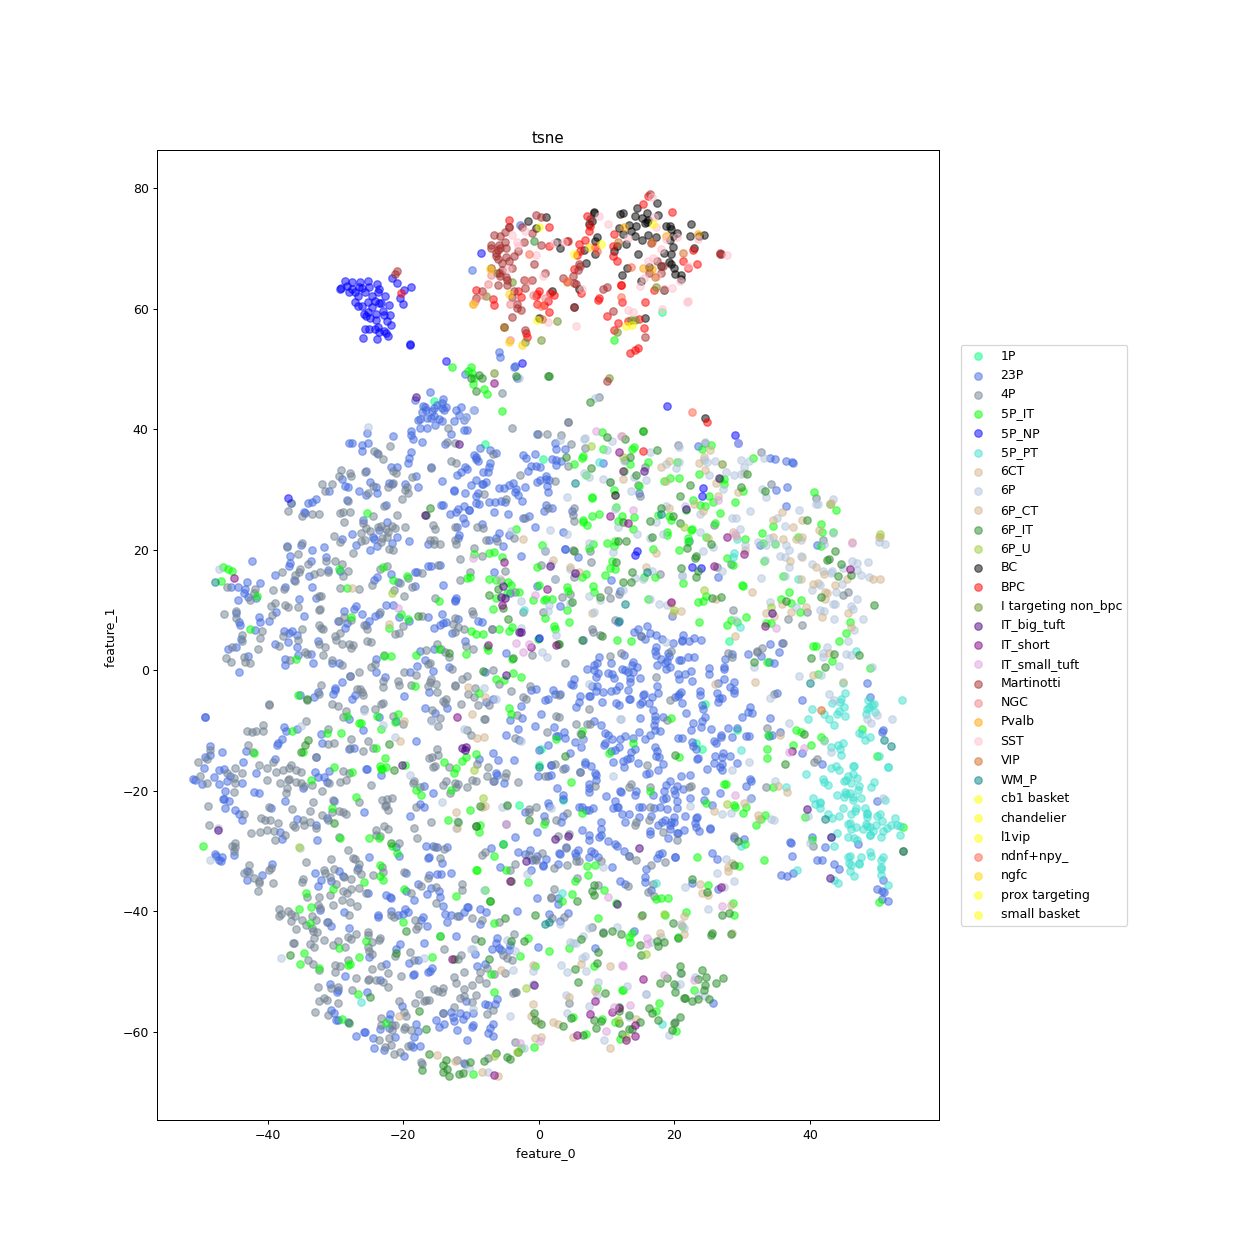

array([[-31.59593  , -33.625526 ],
       [ -4.8202367, -10.782522 ],
       [  7.981412 ,  20.898699 ],
       ...,
       [-23.572    ,  61.04294  ],
       [  8.627871 , -53.79841  ],
       [ 21.316221 ,  67.92365  ]], dtype=float32)

In [87]:
import dimensionality_reduction_ml as dru
dru.dimensionality_reduction_by_method(
    method="tsne",
    X=X[y!= "Unsure"],
    y = y[y != "Unsure"],
    n_components =2,
    plot=True,
    plot_kwargs=dict(
    target_to_color = ctu.cell_type_fine_color_map,
        ndim = 3,
    )
    
)

<IPython.core.display.Javascript object>


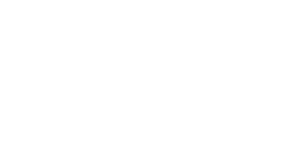

array([[-32.23094  ,  30.107903 ],
       [-13.0130825,   7.149002 ],
       [ 22.438063 ,   3.5898178],
       ...,
       [ 60.978836 ,  29.124115 ],
       [-51.227245 ,  -9.689632 ],
       [ 67.466446 , -18.533266 ]], dtype=float32)

In [88]:
import dimensionality_reduction_ml as dru
dru.dimensionality_reduction_by_method(
    method="tsne",
    X=X_pca[y!= "Unsure"],
    y = y[y != "Unsure"],
    n_components =2,
    plot=True,
    plot_kwargs=dict(
    target_to_color = ctu.cell_type_fine_color_map,
        ndim = 3,
    )
    
)